# Parcours Data Analyst - V1
# Projet n°9 : Prédisez la demande en électricité
**Auteur** : Benoit ANTIGNY <br />
**Mentor** : Zied JEMAI <br />

**Date de création** : 15/10/2021 <br />
**Dernière mise à jour** : 09/11/2021

<hr style="border:3px solid dark"> </hr>

**Problématique** : Estimer la demande en électricité de l'année suivante pour ajuster la production.

**Objectif du projet** : Créer et comparer différentes modélisations de séries temporelles en évaluant leur capacité prédictive sur la consommation électrique mensuelle.

##  Paramètres et déclaration des fonctions

<hr style="border:1px solid dark"> </hr>

### Importations des librairies

In [1]:
%matplotlib inline
%load_ext pycodestyle_magic

import time
import warnings

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import pmdarima as pm
import scipy.stats as stats
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import *
from plt_params import plt_params
from functions import *


from IPython.core.display import display, Markdown, Latex, HTML
HTML("""<style> {text-align: center; vertical-align: middle} </style>""")

### Python linting : pep8 

Permet d'alerter sur les problèmes de forme du code

In [2]:
%pycodestyle_on

### Paramètres

**Options d'affichage de pandas**

In [3]:
pd.set_option('display.max_row', 25)
pd.set_option('display.max_column', 12)

**Personnalisation des parmètres d'affichage par défaut**

In [4]:
plt_params()

In [5]:
%pycodestyle_off  # pour éviter une erreur pycodestyle

# boxplot props
props = {
    'boxprops':{'edgecolor':'black'},
    'meanprops':{'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'flierprops':{'marker':'o', 'markerfacecolor':'white'}
}

%pycodestyle_on

**Statistique**

In [6]:
alpha = 0.05  # Seuil des tests statistiques

### Fichiers sources

**Importation des données de consommation électrique**

source : https://www.rte-france.com/eco2mix/telecharger-les-indicateurs

In [7]:
# Consommation électrique en France
dataset = pd.read_csv('fichiers_P9/data_projet9.xls',
                      usecols=['Mois', 'Territoire', 'Consommation totale'],
                      sep='\t')

# Filtrage pour récupérer les données de la France
dataset = dataset[dataset['Territoire'] == 'France'].reset_index(drop=True)

# Nettoyage du jeu de données et trie des valeurs par ordre chronologique
dataset = dataset.drop('Territoire', axis=1)
dataset = dataset.rename(columns={'Mois': 'date',
                                  'Consommation totale': 'conso'})
dataset = dataset.set_index('date')
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.sort_index()

Description du contenu de ce fichier : <br>
https://assets.rte-france.com/prod/public/2020-07/éCO2mix%20-%20Description%20des%20fichiers%20des%20données%20en%20énergie.pdf

**Importation des données "Degré Jour Unifié"**

source : https://cegibat.grdf.fr/simulateur/calcul-dju

Les données sont disponibles jusqu'au 15/06/21. Nous conserverons les données jusqu'au 31/05/2021 pour notre étude puisqu'il nous faut des mois complets pour ne pas sous estimer la contribution de la température. 

In [8]:
dju = pd.DataFrame()

with warnings.catch_warnings(record=True):  # Permet d'éviter un warning
    warnings.simplefilter("always")         # sans incidence

    for i in range(1, 4):
        num = str(i)
        dju = dju.append(pd.read_excel('fichiers_P9/dju_H' + num + '.xlsx',
                                       header=None, skiprows=12).iloc[:, :13])

# Colonne année
dju = dju.rename(columns={0: 'year'})

# Aggrégation par année des différentes stations
dju = dju.groupby('year').mean().reset_index()

# Noms des colonnes
dju.columns = ['year', '01', '02', '03', '04', '05', '06',
               '07', '08', '09', '10', '11', '12']

# melt columns
dju = pd.melt(dju, id_vars='year', var_name='month', value_name='DJU')

# Colonne date + réarrangement de la table
dju['date'] = dju['year'].astype(str) + '-' + dju['month']
dju = dju[['date', 'DJU']]
dju = dju.set_index('date')
dju.index = pd.to_datetime(dju.index)

# Tri des valeurs par odre chronologique
dju = dju.sort_index()

# Suppression des valeurs après le 31/05/21
dju = dju[dju.index < pd.to_datetime('2021-06')]

source warning : https://stackoverflow.com/questions/66214951/how-to-deal-with-warning-workbook-contains-no-default-style-apply-openpyxls

### Dossier de sauvegarde

In [9]:
save = r'C:\Users\Benoit\Desktop\OpenClassrooms_Formation\P9\figure'

## Description de la série temporelle initiale

- **Taille** : 116 lignes x 1 colonne
- **Types de variables** : 1 variable quantitative (conso)
- **Valeurs manquantes** : aucune <br />
<br />
- **Années des données** : 2012 à 2021, 116 mois (9 ans et 8 mois)
- **Unité de la variable quantitative** : GWh

,conso
date,
2012-01-01,51086
2012-02-01,54476
2012-03-01,43156
2012-04-01,40176
2012-05-01,35257


Nombre de lignes : 116
Nombre de colonnes : 1 

Nombre de variables de type int64 : 1
 
Pourcentage de valeurs manquantes par variable
conso    0.0
dtype: float64


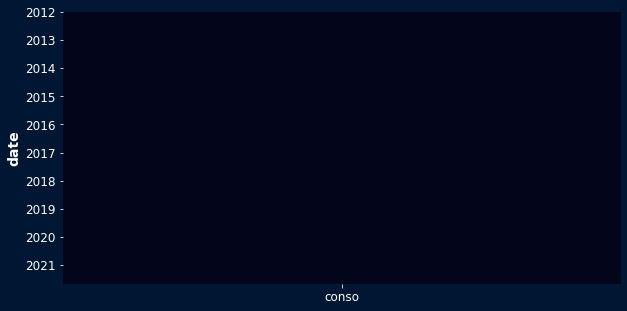

Premier mois : 2012-1
Dernier mois : 2021-8


In [10]:
data = dataset.copy()  # Copie du dataset d'origine

exploration_forme(data)  # Résumé du contenu initial

In [11]:
check_valeurs(data, data.keys())  # Vérification du formatage

Colonne Index(['conso'], dtype='object') 

Valeurs qui ne suivent pas le formatage défini :

[] 

Nombre d'occurence par valeur :

Series([], dtype: int64) 

Nombre de valeur total dont le formatage est différent : 0
----------------------------------------------------------------------------------------------------


Les données conservées pour la suite correspondent à l'intersection des dates des deux séries temporelles (Consommation + Degré Jour Unifié).

In [12]:
# Intersection des deux dataframes
data = data.merge(dju, how='right', left_index=True, right_index=True)

# Ajout de la fréquence pour éviter un warning
data.index = pd.DatetimeIndex(data.index, freq='infer')

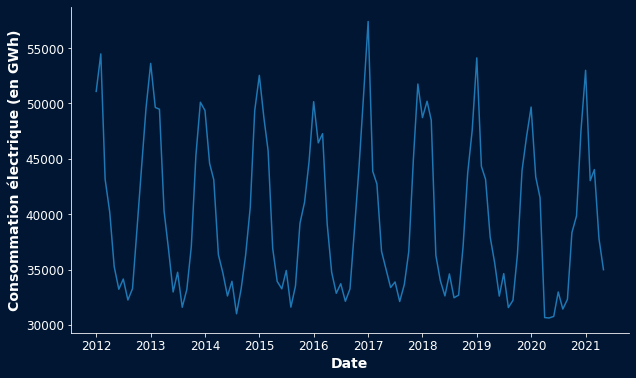

In [13]:
# Affichage de la série temporelle "Consommation"
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=data['conso'], legend=False)
sns.despine()

plt.xlabel('Date')
plt.ylabel('Consommation électrique (en GWh)')

plt.savefig(save + r'\01_serie_origine', bbox_inches='tight')

plt.show()

A ce stade, nous avons notre consommation électrique mensuelle. La demande en électricité est sujette à différents facteurs comme la température ou l'exposition à la lumière. Ces facteurs influencent directement la consommation et il peut être intéressant d'en faire abstraction pour déterminer un profil de consommation plus général et d'en tenir compte dans un second temps pour simuler différents cas de figures.
<br>
<br>
Dans la suite, nous allons corriger l'effet de la température en considérant une mesure : le "Degré Jour Unifié".

## Correction de l'effet de température

### Degré Jour Unifié (DJU)

Le **D**egré **J**our **U**nifié ou **DJU** est une mesure de la différence de température entre la température extérieure ($T_e$) et une température de référence ($T_r$). Cette mesure est notamment utilisée pour estimer la consommation d'énergie thermique dans le secteur du bâtiment. Elle permet de quantifier la rigueur du climat.

La température extérieure utilisée correspond à la moyenne entre les températures minimale ($T_{min}$) et maximale ($T_{max}$) sur une période de 24h. La température de référence habituelle est de **18°C**. Il faut donc diviser en deux cette mesure pour prendre en compte les cas suivants :
- $T_e$ < $T_r$ $\rightarrow$ DJU de chauffe
- $T_e$ > $T_r$ $\rightarrow$ DJU de réfrigération

La température moyenne annuelle de la France est comprise entre **9.5°C** et **15.5°C** selon la latitude. Pour simplifier nous utiliserons le **DJU de chauffe** pour ce projet.

Il existe ensuite 2 méthodes de calcul :
- méthode "Météo", dite simple;
- méthode "Professionnels de l'énergie", dite complexe, pour mieux prendre en compte les débuts et fins de période de chauffe/climatisation.

Ici, nous utiliserons la méthode "**Météo**" ce qui nous donne le calcul suivant pour chaque jour :

\begin{equation}
    \begin{array}{ll}
        DJ = 0 ~~~~~~~~~~~~si~~ T_e \geq T_r \\
        DJ = T_e - T_r ~~si~~ T_e < T_r
    \end{array}
\end{equation}

Le **DJU** de chaque mois est ensuite calculé en prenant la somme des **DJ** du mois concerné. <br>
<br>

**Découpage de la France en zones climatiques (RT 2012)**

Pour optimiser les normes de construction, une réglementation thermique a été mise en place en 2012 (**RT 2012**). Cette réglementation prévoit un découpage géographique de la France pour déterminer un niveau d'exigence en terme de consommation énergétique propre à chaque zone. Ces zones (voir illustration ci-dessous) sont déterminées selon les températures hivernales (**H1**, **H2** et **H3**) et estivales (**a**, **b**, **c** et **d**).

Pour prendre en compte ces différences, les **DJU** sont récupérées auprès de 3 stations (une dans chaque zone hivernale) avant d'en prendre la moyenne. <br>
**NB** : Pour augmenter la précision il est possible de considérer toutes les stations disponibles afin d'obtenur une meilleure couverture du territoire.

<img src="https://www.calculcee.fr/img/articles/1607527310.png" alt="Découpage de la France par zone climatique" />

Les données récupérées proviennent des stations suivantes :
- Zone H1 : Dijon-Longvic
- Zone H2 : La Rochelle aérodrome
- Zone H3 : Cannes

In [14]:
dju.head(5)  # Résultat obtenu

,DJU
date,
2012-01-01,345.100000
2012-02-01,435.500000
2012-03-01,219.766667
2012-04-01,195.033333
2012-05-01,83.500000


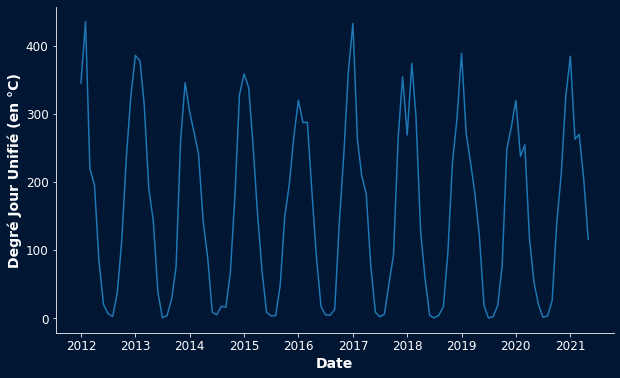

In [15]:
# Affichage de la série temporelle "DJU"
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(data=data['DJU'], legend=False)
sns.despine()

plt.xlabel('Date')
plt.ylabel('Degré Jour Unifié (en °C)')

plt.savefig(save + r'\02_serie_dju', bbox_inches='tight')

plt.show()

### Contribution de l'effet température

Pour déterminer la contribution de l'effet de température sur la consommation électrique en France, nous allons utiliser une régression linéaire entre :

- $y$, la consommation électrique (variable endogène ou expliquée);
- $x$, les DJU (variable exogène ou explicative)

Ce qui sous forme d'équation nous donne :

\begin{equation}
    \begin{array}{ccccc}
        \textrm{Consommation totale} & = & \textrm{Consommation dû à l'effet température} & + & \textrm{Consommation corrigée} \\
        y & = & ax & + & b
    \end{array}
\end{equation}

Ainsi, nous pouvons obtenir la consommation corrigée en isolant le terme correspondant.

#### Modèle complet

In [16]:
X = np.array(data['DJU']).reshape(-1, 1)    # Variable explicative
y = np.array(data['conso']).reshape(-1, 1)  # Variable dépendante

# Sépartion Entraînement / Test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

# Entraînement du modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Score : coefficient de détermination R²
print('R² score :', model.score(X_test, y_test).round(2), '\n')

# Résidus du modèle
resid = y_test - model.predict(X_test)
std_resid = StandardScaler().fit_transform(resid)[:, 0]

# Paramètres du modèle
print('Intercept :', model.intercept_[0],
      '\nCoefficient DJU :', model.coef_[0][0])

R² score : 0.95 

Intercept : 31465.48691873162 
Coefficient DJU : 52.03914411457284


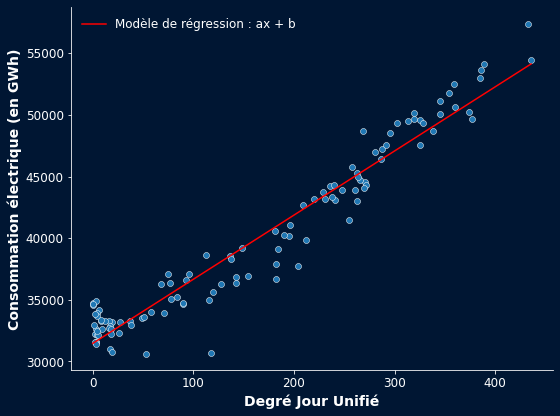

In [17]:
# Comparaison données / modèle
name = save + r'\03_regression'

plot_regression(data, model, name)

Avec ce modèle nous obtenons un score de 95 %. Nous vérifions également la normalité des résidus avec les tests de Shapiro-Wilk et de Kolmogorov-Smirnov compléter par un affichage de la distribution.

**Normalité des résidus**

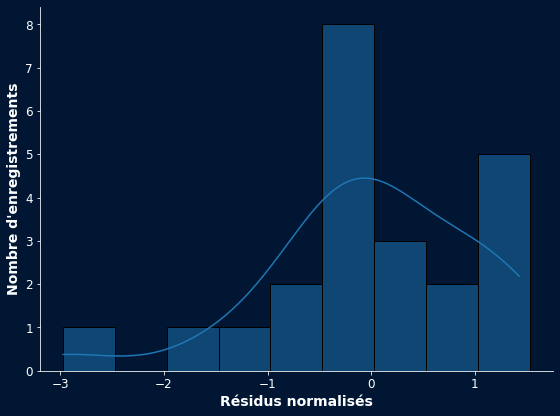

In [18]:
# Distribution des résidus
name = save + r'\04_regression_residu'

plot_residus_std(std_resid, name)

In [19]:
# Tests de normalités
shapiro_test(std_resid, alpha)
ks_test(std_resid, alpha)

Résultat du test de Shapiro-Wilk
- Statistique de test : 0.9289367198944092, p_value : 0.10373181104660034
- H0 validée, Distribution probablement Gaussienne

Resultat du test de Kolmogorov-Smirnov
- Statistique de test : 0.21739130434782608, p_value : 0.6601009653401484
- H0 validée, Distribution probablement Gaussienne


Les résidus semblent suivre une loi normale d'après les tests. Le graphique montre que les résidus sont légèrement biaisés.

Pour comparer, les résultats nous allons réaliser un deuxième modèle en ne prenant en compte que des périodes complètes.

#### Modèle tronqué (sans 2021)

In [20]:
# Sous-ensemble sans les données de 2021
subset = data[data.index < pd.to_datetime('2021-01')]

X = np.array(subset['DJU']).reshape(-1, 1)    # Variable explicative
y = np.array(subset['conso']).reshape(-1, 1)  # Variable dépendante

# Sépartion Entraînement / Test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

# Entraînement du modèle
model_bis = LinearRegression()
model_bis.fit(X_train, y_train)

# Score : coefficient de détermination R²
print('R² score :', model_bis.score(X_test, y_test).round(2), '\n')

# Résidus du modèle
resid = y_test - model_bis.predict(X_test)
std_resid = StandardScaler().fit_transform(resid)[:, 0]

# Paramètres du modèle
print('Intercept :', model_bis.intercept_[0],
      '\nCoefficient DJU :', model_bis.coef_[0][0])

R² score : 0.96 

Intercept : 31758.80313484471 
Coefficient DJU : 51.4425922950459


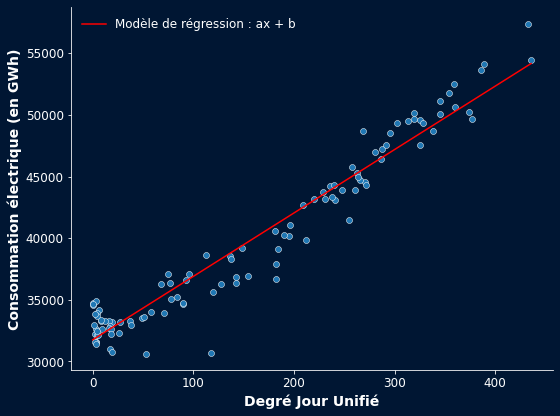

In [21]:
# Comparaison données / modèle
name = save + r'\05_regression_bis'

plot_regression(subset, model_bis, name)

Avec ce modèle nous obtenons un score de 96 %. Nous vérifions également la normalité des résidus avec les tests de Shapiro-Wilk et de Kolmogorov-Smirnov compléter par un affichage de la distribution.

**Normalité des résidus**

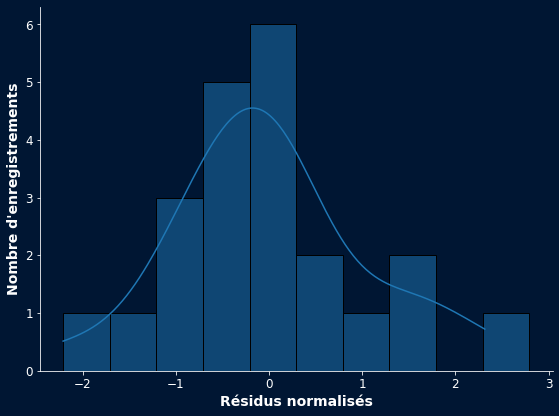

In [22]:
# Distribution des résidus
name = save + r'\06_regression_bis_residu'

plot_residus_std(std_resid, name)

In [23]:
# Tests de normalités
shapiro_test(std_resid, alpha)
ks_test(std_resid, alpha)

Résultat du test de Shapiro-Wilk
- Statistique de test : 0.9622516632080078, p_value : 0.5360962748527527
- H0 validée, Distribution probablement Gaussienne

Resultat du test de Kolmogorov-Smirnov
- Statistique de test : 0.13636363636363635, p_value : 0.9900571661472556
- H0 validée, Distribution probablement Gaussienne


D'un point vue du modèle, celui sans l'année 2021 semble plus précis. La distribution des résidus est également plus proche d'une distribution gaussienne. Nous conserverons néanmoins le modèle complet (avec les mois de 2021) pour être exhaustif.

In [24]:
del subset, model_bis

Nous allons maintenant appliquer la correction à partir du coefficient obtenu avec la régression.

### Application de la correction

In [25]:
# Calcul de la consommation corrigée
data['corrected_conso'] = data['conso'] - (dju['DJU'] * model.coef_[0][0])

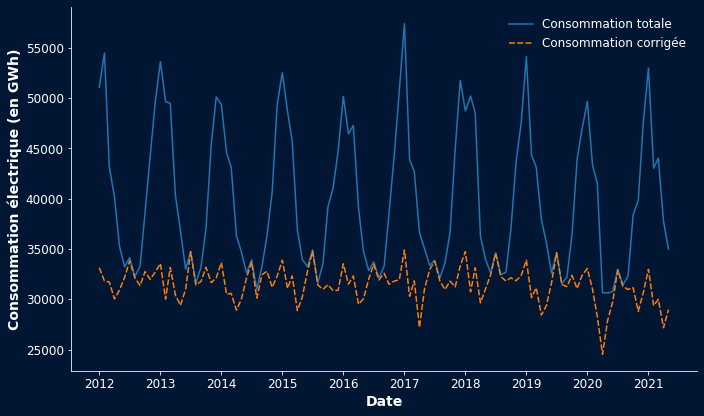

In [26]:
name = save + r'\07_comparaison_series'
labels = ['Consommation totale', 'Consommation corrigée']
plot_compare(data[['conso', 'corrected_conso']], labels, name)

La principale différence entre les deux courbes de consommation est visible pendant les mois les plus froids. A l'inverse, les deux courbes sont quasiment confondues pendant les mois de non-chauffe (entre Juin et Septembre selon les régions de France).

En hiver, la consommation due au chauffage correspond environ aux 2/5ème de la consommation électrique totale.

On remarque également que la consommation corrigée semble stable jusqu'à l'année 2020 ou elle diminue sensiblement. Pour en savoir plus il peut être utile de décomposer la série temporelle. De plus, une décomposition nous permettra de déterminer si la série suit un modèle additif ou multiplicatif.

## Décomposition de la consommation

Une série peut se décomposer en plusieurs éléments :

- une tendance (Trend) notée $T_t$;
- une saisonnalité (Seasonality) notée $S_t$;
- une erreur (Error) notée $\epsilon_t$

Pour un modèle additif, la valeur de la série $X_t$ s'écrit donc de la manière suivante :

$$X_t = T_t + S_t + \epsilon_t$$

Pour un modèle multiplicatif, la valeur de la série $X_t$ s'écrit donc de la manière suivante :

$$X_t = T_t \times S_t \times \epsilon_t$$


Un modèle additif se repère par une saisonnalité et des résidus avec une variance stable. Nous utiliserons Statsmodel et la fonction "seasonal_decompose" pour séparer les éléments et déterminer le type de modèle graphiquement.

In [27]:
# Décomposition de la série temporelle
decomp = seasonal_decompose(data['corrected_conso'],
                            model='additive',
                            extrapolate_trend='freq')

# Soustraction de la composante saisonnière
data['smooth_conso'] = data['corrected_conso'] - decomp.seasonal

# Composantes séparées
data['trend'] = decomp.trend
data['seasonal'] = decomp.seasonal
data['residual'] = decomp.resid

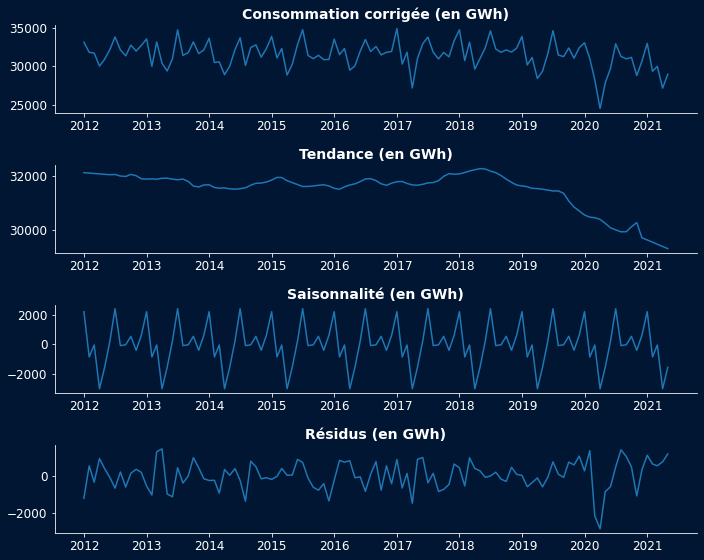

In [28]:
# Affichage des composantes de la série temporelle
fig, axs = plt.subplots(4, figsize=(10, 8))

axs[0].plot(data['corrected_conso'])
axs[1].plot(data['trend'])
axs[2].plot(data['seasonal'])
axs[3].plot(data['residual'])

sns.despine()

axs[0].title.set_text('Consommation corrigée (en GWh)')
axs[1].title.set_text('Tendance (en GWh)')
axs[2].title.set_text('Saisonnalité (en GWh)')
axs[3].title.set_text('Résidus (en GWh)')

fig.tight_layout()

plt.savefig(save + r'\08_decomposition', bbox_inches='tight')

plt.show()

En comparant la série avec les différents éléments qui la compose, nous pouvons voir que celle-ci suit un modèle additif. La saisonnalité est stable et présente un motif périodique qui se répète chaque année. Les résidus semblent à peu près stable bien qu'il y ait une irrégularité (diminution soudaine de la consommation) en fin du premier trimestre de 2020.

Il est également possible d'observer la consommation corrigée désaisonnalisée en soustrayant le terme de saisonnalité à la série temporelle.

In [29]:
data[['corrected_conso', 'smooth_conso']]

,corrected_conso,smooth_conso
date,,
2012-01-01,33127.291366,30920.109992
2012-02-01,31812.952738,32667.512367
2012-03-01,31719.530762,31765.814455
2012-04-01,30026.632260,33030.393255
2012-05-01,30911.731466,32469.525016
...,...,...
2021-01-01,32980.214450,30773.033076
2021-02-01,29361.255394,30215.815023
2021-03-01,29994.777470,30041.061164


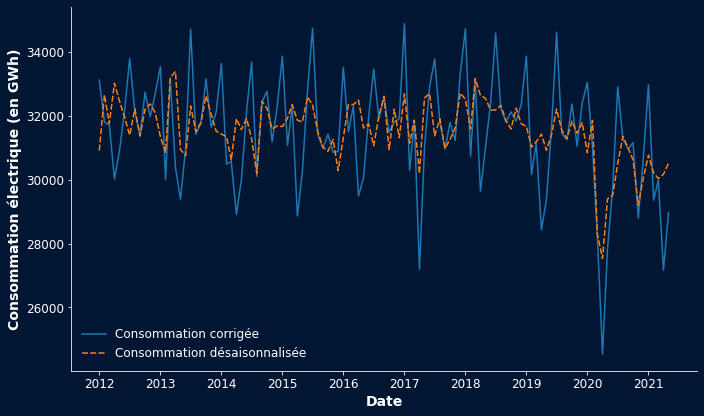

In [30]:
name = save + r'\09_comparaison_decomp'
labels = ['Consommation corrigée', 'Consommation désaisonnalisée']
plot_compare(data[['corrected_conso', 'smooth_conso']], labels, name)

Avec la série désaisonnalisée, la tendance est un peu plus visible qu'avec le signal d'origine. De plus, le creux au mois d'avril 2020 est compris dans le terme d'erreur (résidu). Cette valeur est bien due à une situation anormale puisqu'elle correspond au début de la crise sanitaire du Covid-19 en France. Cette crise a entraîné un boulversement des habitudes et une forte réduction d'affluence dans les bureaux et les transports notamment.

Maintenant que nous avons décrit notre série temporelle, il est temps de passer à l'étape de création du modèle prédictif <br>
<br>

## Mise en place des modèles

Nous allons maintenant préparer deux types de modèles :

- un modèle de **Holt-Winters** (modèle déterministe)
- un modèle **SARIMA** (Seasonal Auto Regressive Integrated Moving Average, modèle stochastique)

### Modèle de Holt-Winters

**Source** : https://otexts.com/fpp2/expsmooth.html

**Principe du modèle** <br>
Méthode empirique (déterministe) de lissage exponentiel. Le modèle pondère les observations en favorisant les plus récentes (poids plus important pour les dernières valeurs et décroissance exponentielle en approchant les plus anciennes). <br>
Le modèle de Holt-Winters applique un triple lissage exponentiel pour réduire (voir éliminer) les variations aléatoires et lisser la tendance tout en capturant la saisonnalité de la série. <br>
La méthode permet de déterminer les paramètres $\alpha$, $\beta$ et $\gamma$ qui correspondent respectivement aux coefficients de lissage des composantes de niveau de base (moyenne locale), tendance (variation entre deux points) et saisonnalité (déviation par rapport à la moyenne locale).


**Limites du modèle** <br>
Le lissage exponentiel fonctionne mieux quand la série est à peu près stationnaire (pas de forte croissance ou décroissance en tendance ou de variations saisonnières, composantes stables). <br>
De plus, le modèle étant déterministe il y a peu de marge d'amélioration pour obtenir un meilleur résultat. <br>
<br>

#### Construction du modèle

Comme vu lors de la décomposition, la série suit un modèle additif. Les paramètres du modèle de Holt-Winters seront ajustés en conséquence.

Le modèle sera validée en effectuant une séparation du jeu de données en un set d'entraînement et un set de test. Le set de test contiendra les 12 derniers mois (une période).

In [31]:
# Création du modèle
hw_model = ExponentialSmoothing(data['corrected_conso'],
                                seasonal_periods=12,
                                trend='add',
                                seasonal='add',
                                initialization_method='legacy-heuristic')

hw_results = hw_model.fit()

# Résidus standardisés
std_resid = np.array(hw_results.resid.values).reshape(-1, 1)
std_resid = StandardScaler().fit_transform(std_resid)
std_resid = std_resid.reshape(len(std_resid))

print(hw_results.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:          corrected_conso   No. Observations:                  113
Model:             ExponentialSmoothing   SSE                       90295212.923
Optimized:                         True   AIC                           1567.806
Trend:                         Additive   BIC                           1611.445
Seasonal:                      Additive   AICC                          1575.083
Seasonal Periods:                    12   Date:                 Thu, 11 Nov 2021
Box-Cox:                          False   Time:                         12:19:09
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.1460588                alpha                 True
smoothing_trend          

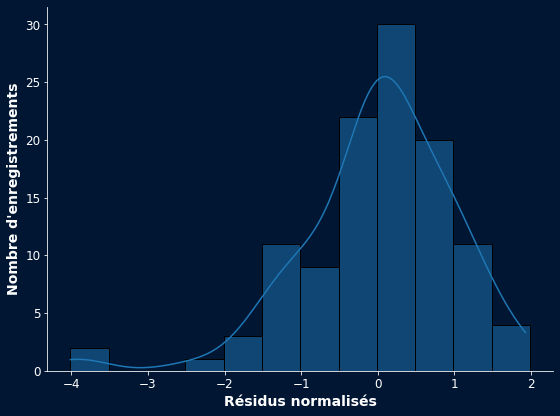

In [32]:
# Distribution des résidus
name = save + r'\10_hw_residu'

plot_residus_std(std_resid, name)

In [33]:
# Tests de normalités
shapiro_test(std_resid, alpha)
ks_test(std_resid, alpha)

Résultat du test de Shapiro-Wilk
- Statistique de test : 0.9364581108093262, p_value : 4.242068462190218e-05
- H0 rejettée, Distribution probablement non Gaussienne

Resultat du test de Kolmogorov-Smirnov
- Statistique de test : 0.11504424778761062, p_value : 0.4448221449652392
- H0 validée, Distribution probablement Gaussienne


#### Test a posteriori

In [34]:
# Split de la série temporelle
train = data.iloc[:-12, :]['corrected_conso']
test = data.iloc[-12:, :]['corrected_conso']

# Modèle tronqué
hw_model_test = ExponentialSmoothing(train,
                                     seasonal_periods=12,
                                     trend='add',
                                     seasonal='add',
                                     initialization_method='legacy-heuristic')

hw_results_test = hw_model_test.fit()

# Résidus standardisés
std_resid = np.array(hw_results_test.resid.values).reshape(-1, 1)
std_resid = StandardScaler().fit_transform(std_resid)
std_resid = std_resid.reshape(len(std_resid))

# Prévision sur la dernière année
hw_pred_test = hw_results_test.forecast(12)

print(hw_results_test.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:          corrected_conso   No. Observations:                  101
Model:             ExponentialSmoothing   SSE                       82843576.023
Optimized:                         True   AIC                           1407.352
Trend:                         Additive   BIC                           1449.194
Seasonal:                      Additive   AICC                          1415.693
Seasonal Periods:                    12   Date:                 Thu, 11 Nov 2021
Box-Cox:                          False   Time:                         12:19:10
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2341612                alpha                 True
smoothing_trend          

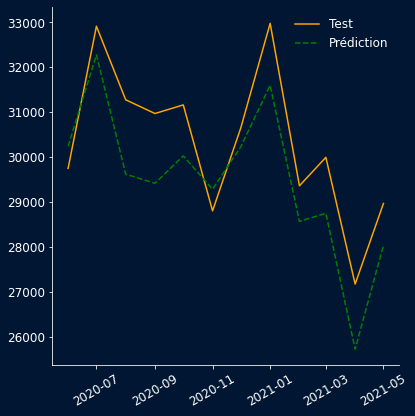

In [35]:
# Zoom sur la partie test
name = save + r'\11_hw_test_pred'
plot_test(train, test, hw_pred_test, name, zoom=True)

In [36]:
# Métriques de qualité de régression
reg_metrics(test, hw_pred_test)

Mean Absolute Percentage Error : 0.033502216938392775
Mean Absolute Error : 1015.334388186956
Median absolute Error : 1033.7972083283075
Root Mean Squared Error : 1101.970036511912


La prévision présente un taux d'erreur d'environ 3.4% et a tendance à sous-estimer la consommation bien qu'elle reste proche de celle mesurée (métriques comprises entre 1000 et 1100 GWh).

Le premier modèle étant créé, nous allons maintenant nous occuper du modèle SARIMA.

### Modèle SARIMA

**Source** : https://otexts.com/fpp2/arima.html

**Principe du modèle** <br>
Les modèles ARIMA (**A**uto**R**egressive **I**ntegrated **M**ooving **A**verage) fournissent une approche complémentaire  au lissage exponentiel. En effet, le lissage exponentiel s'appuie sur une description de la tendance et de la saisonnalité alors que les modèles ARIMA s'intéressent aux autocorrélations présentent dans les données. <br>
<br>

Les modèles ARIMA sont une combinaisons des modèles **AR** (**A**uto**R**egressive) et **MA** (**M**ooving **A**verage). <br>

**Modèles AR($p$)** : Régression linéaire utilisant une combinaison linéaire des valeurs passées de la variable. L'ordre $p$ du modèle indique le nombre de termes passés (lag) à prendre en compte.

**Modèles MA($q$)** : Régression linéaire utilisant une combinaison linéaire des erreurs de prédictions des valeurs passées. L'ordre $q$ du modèle indique le nombre de termes d'erreur à prendre en compte. <br>
<br>

**Stationnarité** <br>
Ces modèles font parti des processus dits "stationnaires". L'une des hypothèses fondamentales de ces méthodes réside dans la stationnarité de la série étudiée. Il est cependant possible de travailler avec une série non stationnaire en utilisant des transformations telles que la différenciation (que nous utiliserons ici). La différenciation consiste à soustraire à chaque terme un terme passé de la série temporelle. <br>

Une différenciation d'ordre 1 s'écrit :
$$y^{'}_{t} = y_t - y_{t-1}$$ <br>

Les modèles **SARIMA**  ajoutent des composantes saisonnières (dans les régressions linéaires des modèles **AR** et **MA**) que les modèles **ARIMA** ne prennent pas en compte. Les modèles saisonniers s'écrivent sous la forme suivante :

$$\text{SARIMA : } ~~ (p, d, q) ~\times~ (P, D, Q)_m$$

avec

- $m$, le nombre d'observation par année (termes par période);
- $p$ et $P$, les ordres du modèle $AR$;
- $d$ et $D$, les ordres de différenciation;
- $q$ et $Q$, les ordres du modèle $MA$.

Les paramètres en minuscule ($p$, $d$ et $q$) gèrent la partie non-saisonnière de la régression alors que les autres ($P$, $D$ et $Q$) s'occupent de la partie saisonnière.

**Détermination des paramètres** <br>
La détermination de ces paramètres s'appuie sur 3 graphiques :
- la série temporelle, représentant les variations temporelles de la variable complétée par un test de stationnarité;
- l'autocorrélogramme, représentant les autocorrélations entre deux termes $y_t$ et $y_{t-k}$ (avec $k$ le lag). Ces valeurs sont calculées par la fonction d'autocorrélation (**ACF**);
- l'autocorrélogramme partiel, représentant les autocorrélations entre deux termes $y_t$ et $y_{t-k}$ après avoir retirés l'effet des termes intermédiaires. Ces valeurs sont calculées par la fonction d'autocorrélation partielle (**PACF**).

#### Stationnarisation de la série

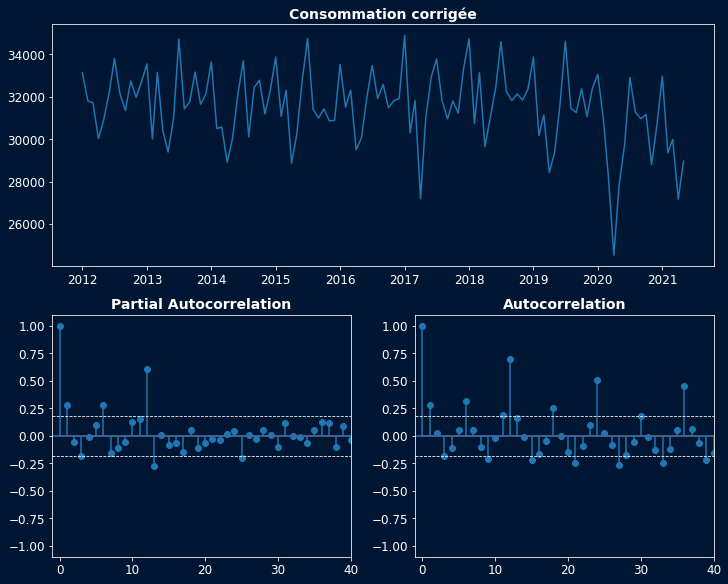

In [37]:
# Série d'origine (consommation corrigée)
size = len(data['corrected_conso'])

name = save + r'\12_sarima_correlogrammes'
titre = 'Consommation corrigée'  # Titre
plot_sarima(data['corrected_conso'], size, name, titre)

In [38]:
# Test de stationnarité
adf_test(data['corrected_conso'], alpha)

Resultat du test de Dickey-Fuller
- ADF statistique-0.5072006065970144, p_value : 0.8906036702095839
- H0 validée, Série probablement instationnaire


La série d'origine est clairement non stationnaire et présente une saisonnalité. Nous commencerons par une différenciation saisonnière pour voir si nous retrouvons une série stationnaire.

In [39]:
# Différenciation en tendance
dif_12 = data['corrected_conso'].diff(12)

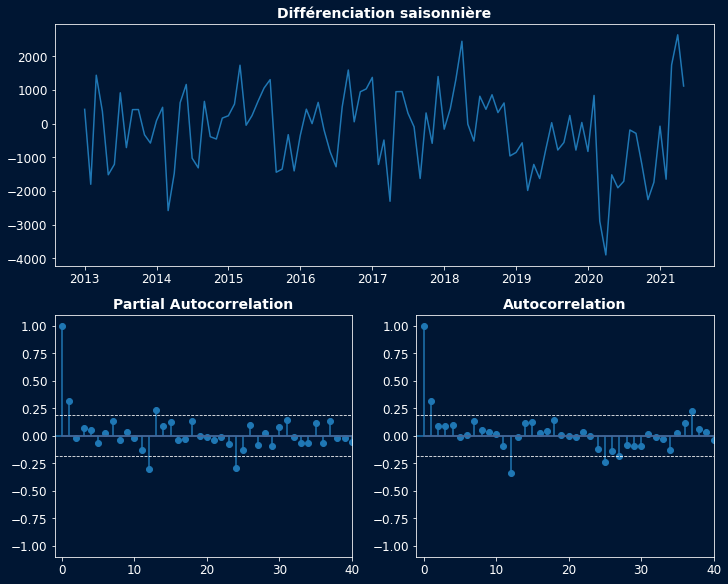

In [40]:
name = save + r'\13_sarima_diff_12'
titre = "Différenciation saisonnière"  # Titre
plot_sarima(dif_12[12:], size, name, titre)

In [41]:
# Test de stationnarité
adf_test(dif_12[12:], alpha)

Resultat du test de Dickey-Fuller
- ADF statistique-2.4722241519802615, p_value : 0.12237956953887852
- H0 validée, Série probablement instationnaire


Le test ADF rejette la stationnarité. Nous allons maintenant effectuer une différeciation d'ordre 1.

In [42]:
# Différenciation en tendance
dif_12_1 = dif_12.diff(1)

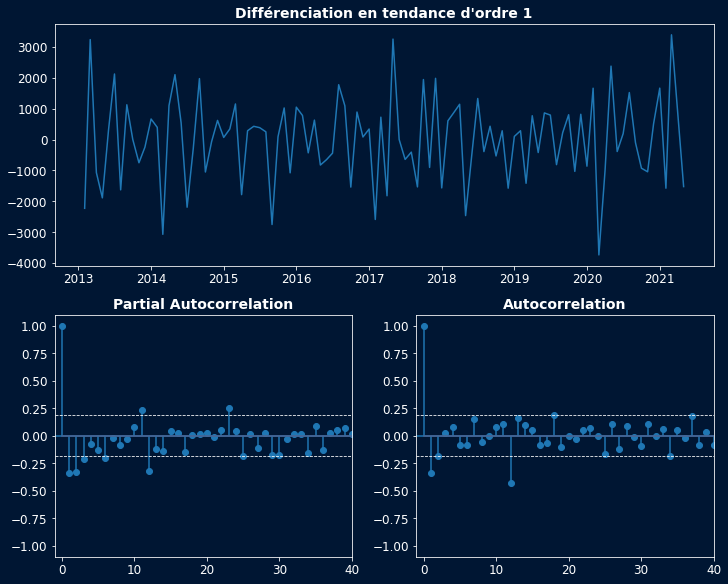

In [43]:
name = save + r'\14_sarima_diff_12_1'
titre = "Différenciation en tendance d'ordre 1"  # Titre
plot_sarima(dif_12_1[13:], size, name, titre)

In [44]:
# Test de stationnarité
adf_test(dif_12_1[13:], alpha)

Resultat du test de Dickey-Fuller
- ADF statistique-3.731459878586795, p_value : 0.003691785060947138
- H0 rejettée, Série probablement stationnaire


La série semble stationnarisée. Le test Augmenté de Dickey-Fuller confirme l'observation obtenue par la lecture du graphique de la série temporelle. Les autocorrélogrammes comporte davantage de lags significatifs après cette seconde différenciation ce qui peut signifié que la série a trop été différencié. Nous allons donc conserver la différenciation saisonnière pour créer notre premier modèle.

A ce stade, il nous faut déterminer les paramètres liés aux modèles **AR** ($p$ et $P$) et **MA** ($q$ et $Q$) à l'aide des autocoréllogrammes.

#### Construction du modèle

A ce stade notre premier modèle doit être de la forme suivante :
$$\text{SARIMA : } ~~ (p, 0, q) ~\times~ (P, 1, Q)_{12}$$

Les facteurs peuvent être déterminés graphiquement en observant les autocorrélogrammes (**ACF** et **PACF**).

Il est important de noter que les graphiques ne servent qu'à déterminer si $p$ et/ou $P$ sont positifs ou $q$ et/ou $Q$. Nous ne pourrons déterminer que par itérations successives si les termes liés au modèle **AR** et au modèle **MA** doivent être positifs.

En observant l'autocorrélogramme **ACF** nous remarquons que le premier lag ainsi que les lag 12 et 24 sont significatifs.

Pour commencer, le premier modèle étudié sera donc de la forme :
$$\text{SARIMA : } ~~ (0, 0, 1) ~\times~ (0, 1, 1)_{12}$$

In [45]:
model1 = SARIMAX(data['corrected_conso'],
                 order=(0, 0, 1),
                 seasonal_order=(0, 1, 1, 12))

results1 = model1.fit()

# Résidus standardisés
std_resid = np.array(results1.resid.values).reshape(-1, 1)
std_resid = StandardScaler().fit_transform(std_resid)
std_resid = std_resid.reshape(len(std_resid))

print(results1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    corrected_conso   No. Observations:                  113
Model:             SARIMAX(0, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -853.793
Date:                            Thu, 11 Nov 2021   AIC                           1713.587
Time:                                    12:19:16   BIC                           1721.432
Sample:                                01-01-2012   HQIC                          1716.763
                                     - 05-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1896      0.042      4.464      0.000       0.106       0.273
ma.S.L12      -0.0353      0.018   

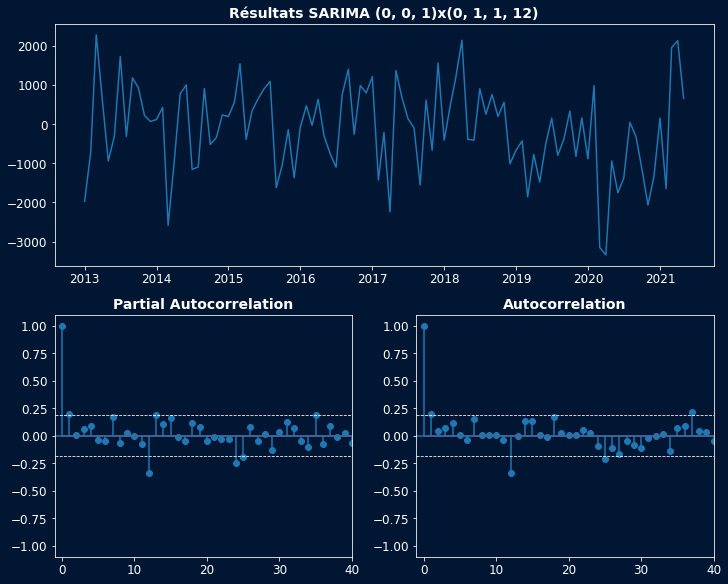

In [46]:
name = save + r'\15_sarima_model_1'
titre = "Résultats SARIMA (0, 0, 1)x(0, 1, 1, 12)"  # Titre
plot_sarima(results1.resid[12:], size, name, titre)

Les paramètres du modèle ne sont pas tous significatifs et les résidus présentent encore des autocorrélations.

Pour tenter de corriger ce problème nous ajoutons un terme saisonnier à la partie **AR** du modèle, ce qui nous donne le modèle suivant :
$$\text{SARIMA : } ~~ (0, 0, 1) ~\times~ (1, 1, 1)_{12}$$

In [47]:
model2 = SARIMAX(data['corrected_conso'],
                 order=(0, 0, 1),
                 seasonal_order=(1, 1, 1, 12))

results2 = model2.fit()

# Résidus standardisés
std_resid = np.array(results2.resid.values).reshape(-1, 1)
std_resid = StandardScaler().fit_transform(std_resid)
std_resid = std_resid.reshape(len(std_resid))

print(results2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    corrected_conso   No. Observations:                  113
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -853.488
Date:                            Thu, 11 Nov 2021   AIC                           1714.976
Time:                                    12:19:18   BIC                           1725.437
Sample:                                01-01-2012   HQIC                          1719.211
                                     - 05-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1879      0.043      4.384      0.000       0.104       0.272
ar.S.L12       0.2949      0.505   

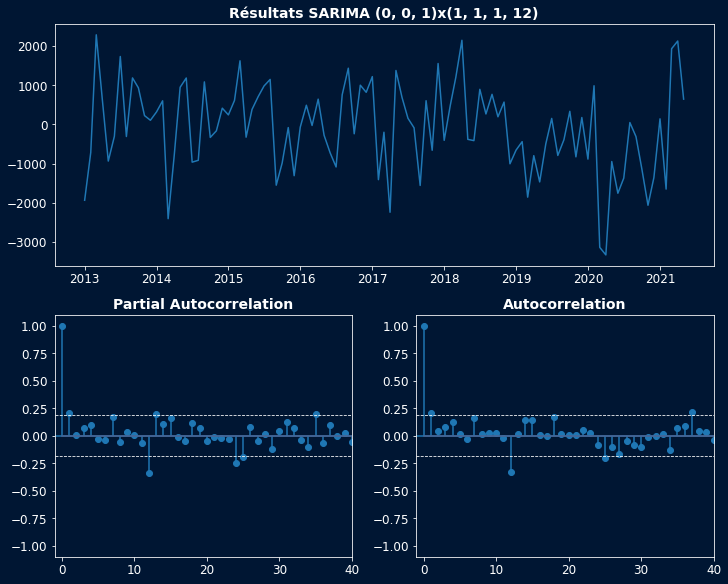

In [48]:
name = save + r'\16_sarima_model_2'
titre = "Résultats SARIMA (0, 0, 1)x(1, 1, 1, 12)"  # Titre
plot_sarima(results2.resid[12:], size, name, titre)

Nous ne notons pas d'amélioration significative avec ce modèle. Afin de gagner en temps, nous allons utiliser la fonction "auto_arima" de la librairie "pmdarima" permettant de trouver le meilleur modèle à appliquer à notre série.

#### Détermination du meilleur modèle

Nous laissons la fonction déterminer les valeurs des paramètres avec pour seule contrainte que chacun d'eux ne peut pas dépasser l'ordre 3.

In [49]:
s_model = pm.auto_arima(data['corrected_conso'],
                        test='adf',
                        max_p=3, max_q=3,
                        m=12,
                        max_P=3, max_Q=3,
                        seasonal=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

s_results = s_model.fit(data['corrected_conso'])

s_resid = pd.Series(s_results.resid(), index=data.index)

s_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1957.309, Time=1.08 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2011.313, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1968.218, Time=0.66 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1950.363, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2663.984, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=2004.396, Time=0.03 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1967.098, Time=0.52 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=1937.301, Time=0.77 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=1961.288, Time=0.94 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=1923.728, Time=2.08 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=inf, Time=2.47 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=1930.999, Time=1.80 sec
 ARIMA(1,0,1)(0,0,3)[12] intercept   : AIC=1928.433, Time=2.54 sec
 ARIMA(0,0,2)(0,0,3)[12] intercept   : AIC=1924.246, Time=2.69 sec
 ARIMA(1,0,0)(0,0,3)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  113
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2, 3], 12)   Log Likelihood                -955.864
Date:                                    Thu, 11 Nov 2021   AIC                           1923.728
Time:                                            12:19:43   BIC                           1940.092
Sample:                                                 0   HQIC                          1930.368
                                                    - 113                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.148e+04    389.254     80.876      0.000    3.07e+04    3.22e+04
ma.L1          0.2740      0.089      3.091      0.002       0.100       0.448
ma.S.L12       0.6649      0.118      5.632      0.000       0.434       0.896
ma.S.L24       0.5952      0.165      3.604      0.000       0.272       0.919
ma.S.L36       0.4004      0.160      2.504      0.012       0.087       0.714
sigma2      1.171e+06   1.69e+05      6.945      0.000    8.41e+05     1.5e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                24.42
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                            -0.87
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

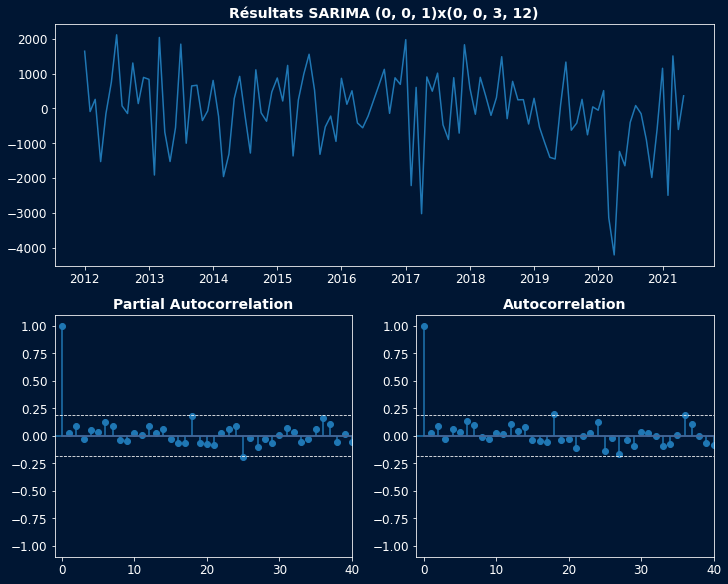

In [50]:
name = save + r'\17_sarima_model_final'
titre = "Résultats SARIMA (0, 0, 1)x(0, 0, 3, 12)"  # Titre
plot_sarima(s_resid, size, name, titre)

Le meilleur modèle obtenu par la procédure ne comprend que des termes **MA** (1 non-saisonnier et 3 saisonniers) et n'est pas différenciée.

Le modèle passe le test de Ljung-Box ($p > 5\%$) ce qui signifie qu'il n'y plus d'autocorrélation entre les résidus (voir corrélogrammes). La distribution des résidus ne passe pas le test de normalité de Jarque-Bera. Nous complétons ce test par les tests de Shapiro-Wilk et de Kolmogorov-Smirnov afin de vérifier que la normalité soit complètement réfutée.

In [51]:
# Résidus standardisés
std_resid = s_results.resid().reshape(-1, 1)
std_resid = StandardScaler().fit_transform(std_resid)
std_resid = std_resid.reshape(len(std_resid))

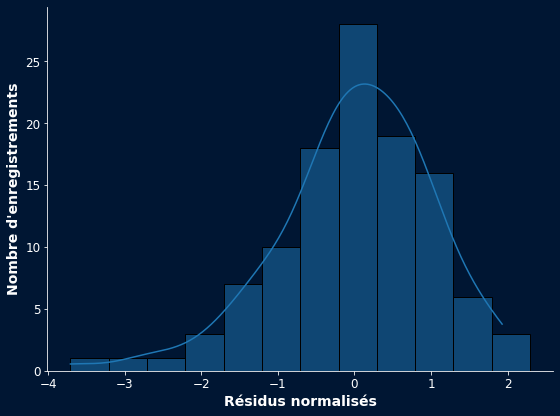

In [52]:
name = save + r'\18_sarima_residu'
plot_residus_std(std_resid, name)

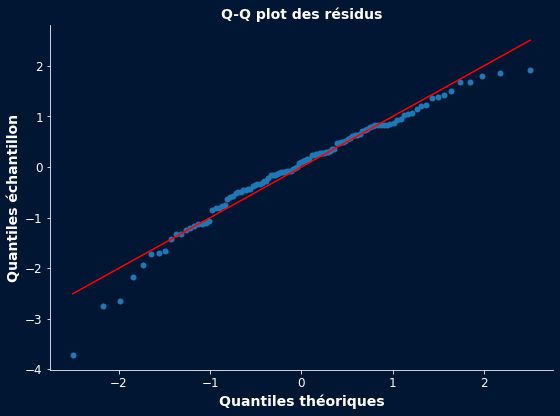

In [53]:
name = save + r'\19_sarima_qqplot'
plot_qqplot(std_resid, name)

In [54]:
# Tests de normalités
shapiro_test(std_resid, alpha)
ks_test(std_resid, alpha)

Résultat du test de Shapiro-Wilk
- Statistique de test : 0.966666042804718, p_value : 0.00639383727684617
- H0 rejettée, Distribution probablement non Gaussienne

Resultat du test de Kolmogorov-Smirnov
- Statistique de test : 0.08849557522123894, p_value : 0.7705288547288659
- H0 validée, Distribution probablement Gaussienne


L'un des deux tests rejette l'hypothèse de normalité. Les données restents cohérentes vis-à-vis d'une distribution normale et nous conservont ce modèle faute de pouvoir en trouver un qui passe tous les tests.

#### Test a posteriori

In [55]:
s_model_test = SARIMAX(train,
                       order=(0, 0, 1),
                       seasonal_order=(0, 0, 3, 12),
                       trend='c')

s_results_test = s_model_test.fit()

# Résidus standardisés
std_resid = np.array(s_results_test.resid.values).reshape(-1, 1)
std_resid = StandardScaler().fit_transform(std_resid)
std_resid = std_resid.reshape(len(std_resid))

print(s_results_test.summary())

s_pred_test = s_results_test.forecast(12)

C:\Users\Benoit\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Benoit\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                         SARIMAX Results                                          
Dep. Variable:                            corrected_conso   No. Observations:                  101
Model:             SARIMAX(0, 0, 1)x(0, 0, [1, 2, 3], 12)   Log Likelihood                -852.524
Date:                                    Thu, 11 Nov 2021   AIC                           1717.049
Time:                                            12:19:48   BIC                           1732.740
Sample:                                        01-01-2012   HQIC                          1723.401
                                             - 05-01-2020                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.163e+04    467.698     67.624      0

Le 3ème terme saisonnier n'est plus significatif au seuil de 5%. Nous allons malgré tout conserver ce modèle et vérifier sa précision.

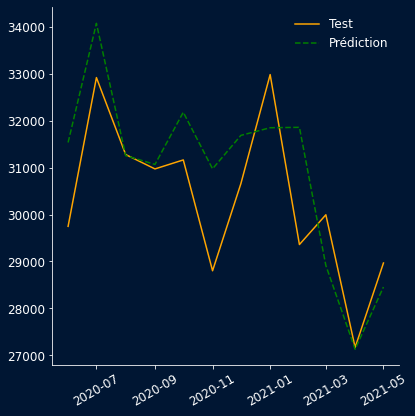

In [56]:
name = save + r'\20_sarima_test_pred'
plot_test(train, test, s_pred_test, name, zoom=True)

In [57]:
# Métriques de qualité de régression
reg_metrics(test, s_pred_test)

Mean Absolute Percentage Error : 0.034567366972940654
Mean Absolute Error : 1044.2202459961525
Median absolute Error : 1053.757605468978
Root Mean Squared Error : 1299.7742709171687


La prévision de ce modèle présente un taux d'erreur d'environ 3.5%.

Maintenant que nous avons nos deux modèles, nous allons pouvoir comparer les prévisions des deux modèles.

### Prévision de l'année suivante

In [58]:
# Prévision 2021-2022 Holt-Winters
hw_pred = hw_results.forecast(12)

# Prévision 2021-2022 SARIMA
s_pred = s_results.predict(12)
s_pred = pd.Series(s_pred, index=hw_pred.index)

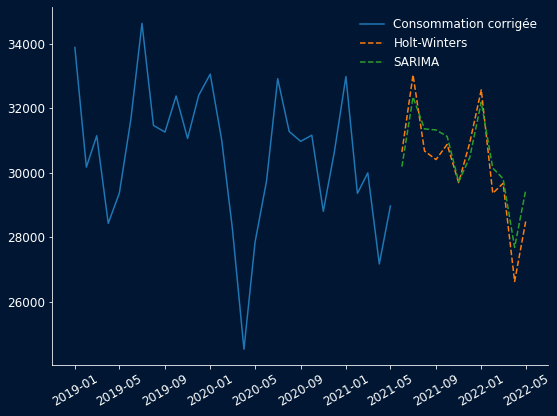

In [59]:
name = save + r'\21_compare_pred'
subset = data[data.index >= pd.to_datetime('2019')]['corrected_conso']
plot_compare_pred(subset, hw_pred, s_pred, name)